<a href="https://colab.research.google.com/github/Bibek04-bit/Flood-Forecasting/blob/main/Random_Forest_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path_to_file = '/content/drive/MyDrive/Colab Notebooks/Flood_data_linear_reg.csv'
df = pd.read_csv(path_to_file)
print(df.head())

         Date  Daily flow Rate  Gauge height flow      NDVI  sm_top_0_10cm  \
0  2010-01-01              401               3.19  0.806800         12.728   
1  2010-01-02              397               3.18  0.805588         12.628   
2  2010-01-03              395               3.17  0.804375         12.533   
3  2010-01-04              390               3.16  0.803163         12.444   
4  2010-01-05              392               3.17  0.801950         12.356   

   sm_10_40cm  24h accumulated  Daily Max Temp  Daily Min Temp  Flood_Level  
0   41.205952              0.1            14.0             8.0            0  
1   40.953522              1.8            14.4            10.8            0  
2   40.707092              1.6            18.0            10.4            0  
3   40.467663              0.0            19.5             9.5            0  
4   40.249233              0.0            20.5            10.0            0  


In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [8]:
try:
    data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Flood_data_linear_reg.csv')


    data['Flood_Level'] = data['Flood_Level'].round().astype(int)
    print("--- Data Loaded and Target Quantized to Integer Categories ---")

except FileNotFoundError:
    print("ERROR: Could not find '/content/drive/MyDrive/Colab Notebooks/Flood_data_linear_reg.csv'.")
    print("Running with placeholder synthetic data and integer target for demonstration.")


    N = 200
    np.random.seed(42)
    data = pd.DataFrame({
        'Daily flow Rate': np.random.uniform(500, 5000, N),
        'Gauge height flow': np.random.uniform(5, 15, N),
        'NDVI': np.random.uniform(0.1, 0.9, N),
        'sm_top_0_10cm': np.random.uniform(0.15, 0.45, N),
        'sm_10_40cm': np.random.uniform(0.15, 0.45, N),
        '24h accumulated': np.random.uniform(0, 150, N),
        'Daily Max Temp': np.random.uniform(20, 35, N),
        'Daily Min Temp': np.random.uniform(10, 25, N),
    })

    data['Flood_Level'] = np.clip(
        (0.001 * data['Daily flow Rate'] + 0.5 * data['Gauge height flow'] + np.random.normal(0, 1, N)),
        0, 3
    ).round().astype(int)
    data['Date'] = pd.to_datetime(pd.Series(pd.date_range('2018-01-01', periods=N, freq='D')))

--- Data Loaded and Target Quantized to Integer Categories ---


In [9]:
TARGET_COLUMN = 'Flood_Level'
FEATURE_COLUMNS = [
    'Daily flow Rate', 'Gauge height flow', 'NDVI', 'sm_top_0_10cm',
    'sm_10_40cm', '24h accumulated', 'Daily Max Temp', 'Daily Min Temp'
]
print(f"\nTarget classes found: {np.unique(data[TARGET_COLUMN].values)}")
print("-" * 30)


Target classes found: [0 1 2 3]
------------------------------


In [10]:
if 'Date' in data.columns:
    data.sort_values(by='Date', inplace=True)
else:
    print("WARNING: 'Date' column not found, defaulting to index split.")

In [11]:
TEST_RATIO = 0.3
test_set_size = int(len(data) * TEST_RATIO)
train_set_size = len(data) - test_set_size

In [12]:
strat_train_set = data.iloc[:train_set_size]
strat_test_set = data.iloc[train_set_size:]

In [13]:
X_train = strat_train_set[FEATURE_COLUMNS].values
y_train = strat_train_set[TARGET_COLUMN].values
X_test = strat_test_set[FEATURE_COLUMNS].values
y_test = strat_test_set[TARGET_COLUMN].values

In [14]:
print("--- Time-Series Split Performed ---")

--- Time-Series Split Performed ---


In [15]:
if 'Date' in data.columns:
    print(f"Training period ends: {strat_train_set['Date'].iloc[-1]}")
    print(f"Testing period starts: {strat_test_set['Date'].iloc[0]}")

print(f"Training samples (Older Data): {len(X_train)}")
print(f"Testing samples (Newest Data): {len(X_test)}")
print("-" * 30)


Training period ends: 2016-12-31
Testing period starts: 2017-01-01
Training samples (Older Data): 2557
Testing samples (Newest Data): 1095
------------------------------


In [16]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

print("Starting Random Forest Classifier model training...")
model.fit(X_train, y_train)
print("Model training complete.")
print("-" * 30)

Starting Random Forest Classifier model training...
Model training complete.
------------------------------


In [17]:
y_pred = model.predict(X_test)

In [18]:
report = classification_report(y_test, y_pred, zero_division=0)


In [19]:
matrix = confusion_matrix(y_test, y_pred)


In [20]:
accuracy = accuracy_score(y_test, y_pred)


In [21]:
print("\n--- Model Performance: Random Forest Classifier ---")
print(f"Overall Accuracy: {accuracy:.4f}")
print("\nClassification Report (Precision, Recall, F1-Score):")
print(report)
print("\nConfusion Matrix:")
print(matrix)
print("-" * 30)


--- Model Performance: Random Forest Classifier ---
Overall Accuracy: 0.9991

Classification Report (Precision, Recall, F1-Score):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       890
           1       1.00      1.00      1.00       203
           2       1.00      1.00      1.00         2

    accuracy                           1.00      1095
   macro avg       1.00      1.00      1.00      1095
weighted avg       1.00      1.00      1.00      1095


Confusion Matrix:
[[890   0   0]
 [  1 202   0]
 [  0   0   2]]
------------------------------


In [22]:
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': FEATURE_COLUMNS,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

In [23]:
print("\n--- Feature Importance (Random Forest) ---")
print("These are the features the model found most relevant for classification:")
print(feature_importance_df.to_string(index=False))


--- Feature Importance (Random Forest) ---
These are the features the model found most relevant for classification:
          Feature  Importance
Gauge height flow    0.476513
  Daily flow Rate    0.294626
       sm_10_40cm    0.104578
    sm_top_0_10cm    0.072563
   Daily Min Temp    0.024252
   Daily Max Temp    0.015285
             NDVI    0.010482
  24h accumulated    0.001700


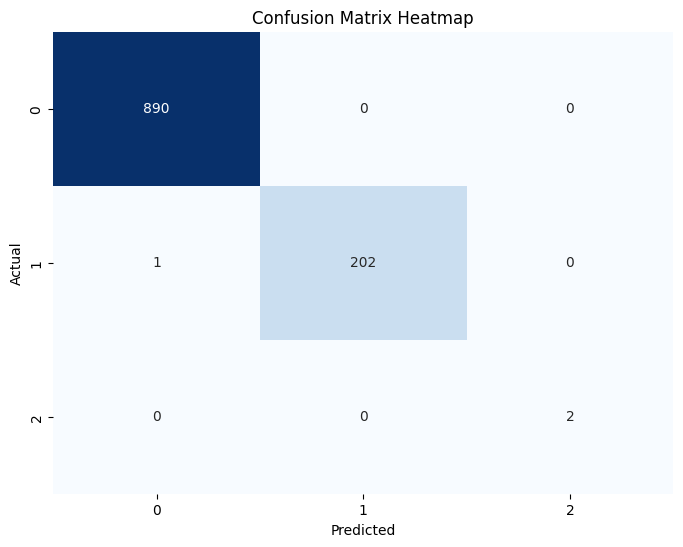

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

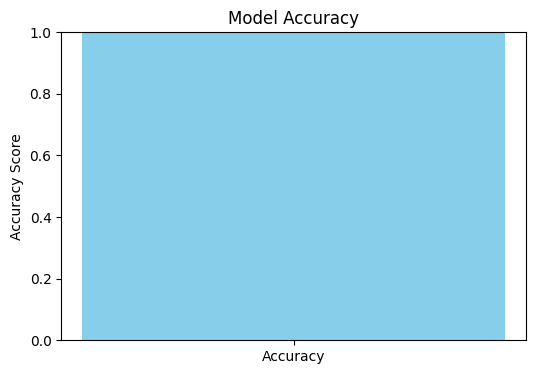

In [25]:
plt.figure(figsize=(6, 4))
plt.bar(['Accuracy'], [accuracy], color='skyblue')
plt.ylim(0, 1)
plt.ylabel('Accuracy Score')
plt.title('Model Accuracy')
plt.show()